# Grid World --- past all grids (agent prefer to visit unvisited grids)
##### Charles Zhang
##### Jun 17

###  1. Cover and Get Back

In [1]:
import numpy as np
import datetime

In [2]:
BOARD_ROWS = 4
BOARD_COLS = 5
START = (0, 0)
END = (0, 0)

In [3]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.state = state    # tuple of the coordinate
        self.is_end = False

    def check_end(self):
        if self.state == END:
            self.is_end = True

    def next_position(self, action):
        if action == "up":
            next_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            next_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)
        # boundary condition 
        if (next_state[0] >= 0) and (next_state[0] < BOARD_ROWS):
            if (next_state[1] >= 0) and (next_state[1] < BOARD_COLS):
                return next_state
        return self.state

In [4]:
class Agent:

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]      # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.05      # learning rate
        self.exp_rate = 1     # epsilon-greedy parameter
        self.decay_gamma = 0.9
        self.Q_values = {}             # init Q table (dict)
        for i in range(BOARD_ROWS):    
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        # init a list to check if each grid is past          
        self.past_all = np.zeros((BOARD_ROWS, BOARD_COLS), dtype=bool).tolist()
        self.steps = []         # store the steps for each episode 
    
    def optimal_action(self):
        # greedy move
        max_value = -10000
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action
    
    def get_action(self):
        """
        The agent should choose randomly among the positions that have
        not been visited, and if all possible positions are visited, 
        then move randomly and receive a negative reward
        """
        if np.random.uniform(0, 1) <= self.exp_rate:
            # Get four potential positions of the current state
            up = self.State.next_position("up")
            down = self.State.next_position("down")
            left = self.State.next_position("left")
            right = self.State.next_position("right")
            # Check if all potential positions are visited
            rule = [self.past_all[up[0]][up[1]] is True,
                    self.past_all[down[0]][down[1]] is True,
                    self.past_all[left[0]][left[1]] is True,
                    self.past_all[right[0]][right[1]] is True ]
            # If all are visited, return a random action
            if all(rule):
                action = np.random.choice(self.actions)
                return action
            # Else try to get an available unvisited position randomly
            else:
                while True:
                    action = np.random.choice(self.actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] is False:
                        return action
                    else:
                        continue
        else:
            return self.optimal_action()
    
    def give_reward(self):
        """
        + 1 reward for visiting the unvisited grid
        -.1 reward for visiting the visited grid
        """
        reward = 0
        if self.past_all[self.State.state[0]][self.State.state[1]] is False:
            reward += 1
        else:
            reward -= .1
        return reward
    
    def set_action(self, action):
        # set current stat past
        curr_state = self.State.state
        self.past_all[curr_state[0]][curr_state[1]] = True
        # get the next state
        next_state = self.State.next_position(action)  
        self.State = State(state=next_state)
        reward = self.give_reward()
        # set the next state past
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
        # give the global reward if finish an epsiode
        if self.State.state==START and self.check_all_past():
            reward += 1
        # update the Q table
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:  
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha*(reward + self.decay_gamma*(max(qs_of_next_state)) -
                            self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action]+delta, 10)

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.is_end = self.State.is_end
    
    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True
    
    def show_path(self):
        for i in range(BOARD_ROWS):
            print('---------------------------------------')
            row_string = "| "
            for j in range(BOARD_COLS):
                best_move = ""
                best_val = -1000
                for a in self.Q_values[(i,j)]:
                    if self.Q_values[(i,j)][a] > best_val:
                        best_val = self.Q_values[(i,j)][a]
                        best_move = a            
                row_string = row_string + " " + best_move + " |"
            print(row_string)
        print('---------------------------------------')

    def train(self, rounds=1000):
        print("Training...")
        for r in range(rounds): 
            self.reset()
            self.exp_rate *= 0.99  # decaying epsilon-greedy
            step = 0
            while True:
                action = self.get_action()
                self.set_action(action)
                self.State.check_end()
                self.is_end = self.State.is_end
                step += 1
                if self.is_end and self.check_all_past():
                    break
                if step > 3000:
                    break
            self.steps.append(step)
        print("Training finished!")

In [5]:
agent = Agent()
start_time = datetime.datetime.now()
agent.train()
end_time = datetime.datetime.now()
time_period = (end_time - start_time).total_seconds()
print(agent.Q_values)

Training...
Training finished!
{(0, 0): {'up': 1.1973081594, 'down': 9.6457656872, 'left': 0.8973426869, 'right': 0.894198924}, (0, 1): {'up': 0.8953721471, 'down': 0.8903587262, 'left': 9.5488774024, 'right': 1.3191995507}, (0, 2): {'up': 0.8755714689, 'down': 0.8799451413, 'left': 9.5602513609, 'right': 0.8794507759}, (0, 3): {'up': 0.8416293229, 'down': 0.849448222, 'left': 9.5706151328, 'right': 0.841998574}, (0, 4): {'up': 0.8160377063, 'down': 0.8149002412, 'left': 9.5800706842, 'right': 0.8193174446}, (1, 0): {'up': 0.8992555329, 'down': 1.1804725688, 'left': 0.9005376749, 'right': 9.6442854963}, (1, 1): {'up': 0.89024487, 'down': 1.103336804, 'left': 0.8960723383, 'right': 9.6426917325}, (1, 2): {'up': 0.9815003242, 'down': 1.0515372709, 'left': 0.8963495865, 'right': 9.6409391684}, (1, 3): {'up': 0.8806075185, 'down': 9.6389846019, 'left': 0.8774535591, 'right': 1.1759524276}, (1, 4): {'up': 9.5886868491, 'down': 0.8586397054, 'left': 0.8619287254, 'right': 0.8591631783}, (2, 

In [6]:
print("Running time: ", time_period)

Running time:  0.686432


In [7]:
agent.Q_values

{(0, 0): {'down': 9.6457656872,
  'left': 0.8973426869,
  'right': 0.894198924,
  'up': 1.1973081594},
 (0, 1): {'down': 0.8903587262,
  'left': 9.5488774024,
  'right': 1.3191995507,
  'up': 0.8953721471},
 (0, 2): {'down': 0.8799451413,
  'left': 9.5602513609,
  'right': 0.8794507759,
  'up': 0.8755714689},
 (0, 3): {'down': 0.849448222,
  'left': 9.5706151328,
  'right': 0.841998574,
  'up': 0.8416293229},
 (0, 4): {'down': 0.8149002412,
  'left': 9.5800706842,
  'right': 0.8193174446,
  'up': 0.8160377063},
 (1, 0): {'down': 1.1804725688,
  'left': 0.9005376749,
  'right': 9.6442854963,
  'up': 0.8992555329},
 (1, 1): {'down': 1.103336804,
  'left': 0.8960723383,
  'right': 9.6426917325,
  'up': 0.89024487},
 (1, 2): {'down': 1.0515372709,
  'left': 0.8963495865,
  'right': 9.6409391684,
  'up': 0.9815003242},
 (1, 3): {'down': 9.6389846019,
  'left': 0.8774535591,
  'right': 1.1759524276,
  'up': 0.8806075185},
 (1, 4): {'down': 0.8586397054,
  'left': 0.8619287254,
  'right': 0.8

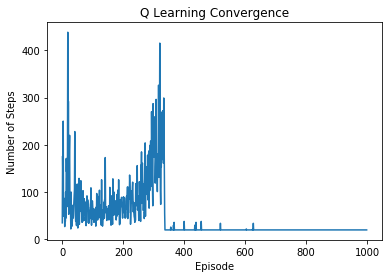

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
x = []
for i in range(1000):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

In [9]:
min(agent.steps)

20

#### Optimal Policy

In [10]:
agent.show_path()

---------------------------------------
|  down | left | left | left | left |
---------------------------------------
|  right | right | right | down | up |
---------------------------------------
|  down | left | left | left | up |
---------------------------------------
|  right | right | right | right | up |
---------------------------------------
